# Frozen Lake

### Import dependencies

In [1]:
# !pip install gymnasium
# !pip install gymnasium[toy_text]
# !pip install IPython
# !pip install tqdm

In [1]:
import random
import gymnasium as gym
import numpy as np
from tqdm import tqdm
import imp
from imp import reload

# set up plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
from IPython.display import clear_output
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')
mpl.rcParams['animation.embed_limit'] = 2**128

C:\Users\carlo\AppData\Local\Temp\ipykernel_6300\3810947690.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


The first step is creating our environment. We will be using `FrozenLake-v1`, as `v0` is not supported anymore. The map we will be using is 4x4, which has this shape:

![map_shape](./imgs/frozen_lake_shape.png)

As we can see in the diagram, there are four types of tiles:

+ Start tile (S): The tile from where the agent starts.
+ Frozen tile (F): A safe tile, in which the agent can land and continue the game.
+ Hole tile (H): Danger tile. If the agent lands on this tile, the game is over, and agent has to return to the starting tile
+ Goal tile (G): Goal of the game. If the agent lands on this tile, the game will be over, but a reward will be attained.

When loading our environment, we can do it in slippery mode, where the agent will move in intended direction with probability of 1/3, but can also move in either perpendicular direction with equal probability of 1/3 in both directions. This makes the game significantly harder, as the agent's choice of the next action will not always be implemented. It will be similar to the use of epsilon during training, which is the option we will be implementing. Thus, for the sake of simplicity, we will stick to the non-slippery version of the game. 

In [3]:
env = gym.make("FrozenLake-v1", map_name="4x4", render_mode='rgb_array', is_slippery=False)
env.reset()

(0, {'prob': 1})

Now that our environment is loaded, we can plot it using the `plot_environment` function, which we can import from `plot_utils.py`

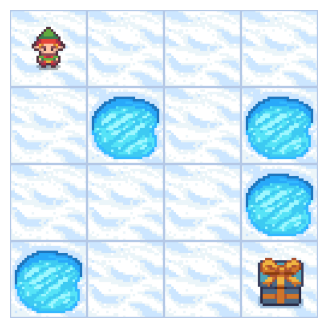

In [4]:
from plot_utils import plot_environment

plot_environment(env=env)

We can see that the image rendered above matches the visual scheme we defined for our game. We can also explore the shape of our states and actions inside this environment:

In [5]:
print("Action Space {}". format(env.action_space))
print("State Space {}.". format(env.observation_space))

Action Space Discrete(4)
State Space Discrete(16).


According to the [documentation](https://www.gymlibrary.dev/environments/toy_text/frozen_lake/), our action space is comprised by four different actions:

+ 0: `LEFT`
+ 1: `DOWN`
+ 2: `RIGHT`
+ 3: `UP`

This means that at each particular location within the grid, the agent has the choice to move in either one of this directions (in this particular implementation of the game there are no forbidden movements).

We also have a state space comprised by 16 different states, which correspond with each one of the tiles that appear in the above grid.  

Let's see what happens if we take a random action inside the environment:

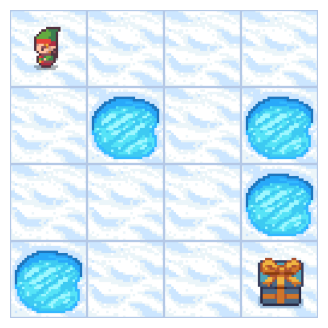

In [6]:
# sample random action
action = env.action_space.sample()
# execute action
step = env.step(action=action)
plot_environment(env=env)

If we execute the previous cell multiple times in a loop we can see how the environment changes with our actions:

In [21]:
import plot_utils
reload(plot_utils)
from plot_utils import plot_animation

frames = []
for i in tqdm(range(10)):
    state = env.reset()[0]
    done = False
    while not done:
        # sample random action
        action = env.action_space.sample()
        # execute action
        next_state, reward, done, truncated, info = env.step(action=action)
        # add environment image to frames
        img = env.render()
        frames.append(img)

# plot_animation(frames, interval=50)

100%|██████████| 10/10 [00:00<00:00, 322.52it/s]


We can see that the agent is not very good at finding the goal. This is because it is not yet trained to do so. 

# Q-learning

We are now going to train the model to learn how to efficiently find the goal in the least number of steps possible. Our first approach in doing so is by using Q-learning. First, we need to initialize our agent:

In [8]:
from agent import Agent
env.reset()

elf = Agent(env=env)

First, we need to define our Q-table, which we will use to keep track of the value of the states at each iteration. In contrast with other approaches, such as TD learning, we are taking into account the action by which the state was reached. Thus, we need to define a grid of 16x4 in which each row corresponds to a particular tile in the grid, whilst each column corresponds to an action

In [9]:
elf.q_table

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

Initially, our grid is initialized to zero, as we do not know the values of the states beforehand. While training, we will update the values in this grid, so that after the process is finished the agent knows the optimal policy for moving in this space.

Now that we have set our Q-table, we need to consider the training hyperparameters, which will define the way we train our agent. There are three main hyperparameters to consider:

+ `alpha`: The learning rate, which determines the speed at which the agent is learning. Values that are close to zero mean that the agent is not able to learn, as the modification of the Q-table is minimal, and thus avoids conversion. However, high values mean that the agent is not retaining enough information about previous steps. In this case, we chose a value of `0.5`
+ `gamma`: The discount factor, which models how the agent values future rewards with respect to the present. A value of 1 will make the agent value future rewards just as much as immediate ones, whilst a gamma of 0 will make the agent completely disregard the future and only focus on the next step. Since our reward function is not detailed enough, we will stay away from low values by choosing a gamma of `0.9`.
+ `epsilon`: This parameter is used for modelling the exploration behavior of the agent. In a classical Q-learning approach, the model learns the optimal policy and executes it (exploitation), but this can cause it to find suboptimal solutions to the problem. To encourage some exploration, we can use a small value of epsilon such that if a random sampling process produces a value that is lower than that of epsilon we will ignore the theoretical best action and will instead perform a random action from the available ones. In this case, we choose a low value of epsilon for training: `0.01`

Finally, we need to consider is the reward scheme. The default implementation of this game assigns a reward of +1 for reaching the goal and a reward of 0 for reaching any other position in the grid. Let's see how training with this default scheme looks like:

In [10]:
elf.q_train(alpha=0.5, gamma=0.5, epsilon=0.01, episodes=1000, save_images=False)

100%|██████████| 5000/5000 [35:24<00:00,  2.35it/s]  


The first thing we notice is that the training process is quite slow. This is due to the fact that the agent is not being penalized for reaching a hole terminal state, which impairs the learning process. 

Let us check the difference in the Q-table after the training process:

In [11]:
elf.q_table

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

Let's plot the performance curve:

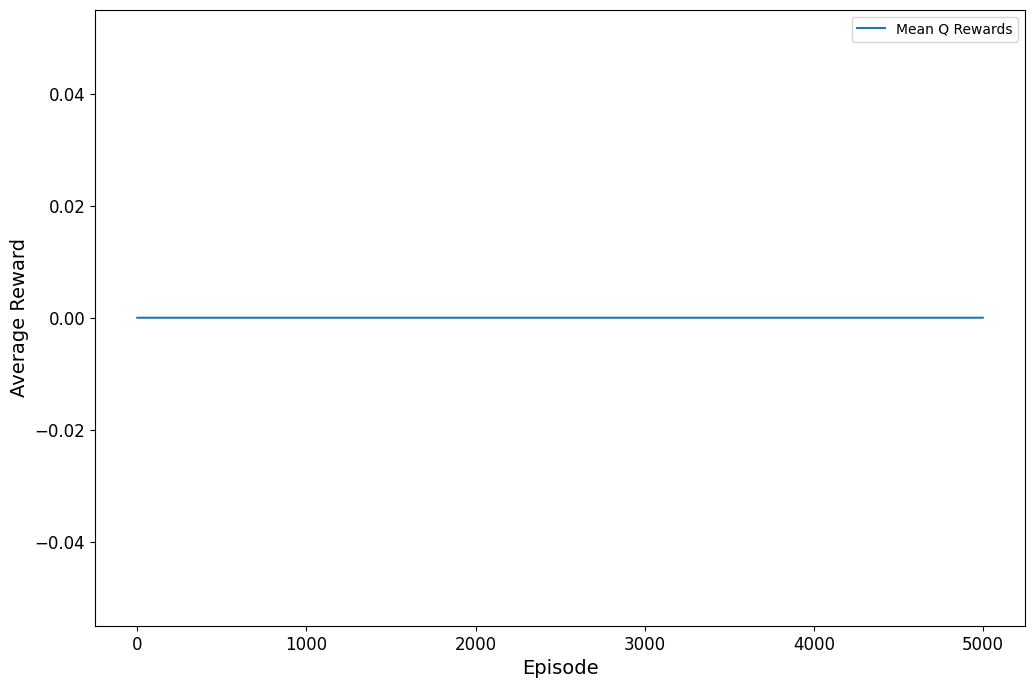

In [12]:
elf.plot_q_training_curve()

Let's now evaluate the number of wins our agent achieved:

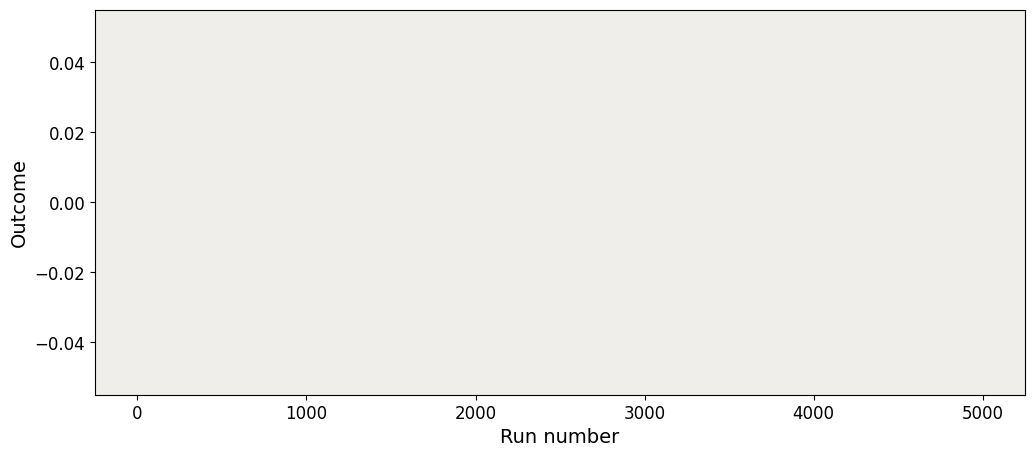

In [13]:
elf.plot_q_training_wins()

Sadly, our agent did not learn anything using this approach...

Clearly, our agent is not very good at this game and it has not reached convergence, as it keeps on making mistakes even after training. This is due to two main reasons:

1. Falling into a hole is not being penalized, as the reward the agent gets for it is neutral. Thus, the model is not learning to conciously avoid failures.
2. There is no penalty for making many moves, which leads to several possible routes to the goal, thus increasing the chances of failing in the process.

By modifying the reward scheme we can take care of these issues. In this approach, the reward for reaching the goal is maintained, but falling into a hole is penalized with −0.2. We hope that this encourages the agent to increase its learning speed, as iterating over the same mistakes is punished. Additionally, stepping into a frozen state has an additional small penalty (-0.01), which is set to encourage the agent to find the shortest path possible to the goal. For more information, refer to this [paper](https://ieeexplore.ieee.org/document/9144562).

For this approach we need to specify the locations of our holes and frozen tiles

In [8]:
# reset env
env.reset()

# define holes and frozen tiles' location
holes = [5, 7, 11, 12]
frozen = [i for i in np.arange(0, 15) if i not in holes]

# create a new agent

elf2 = Agent(env=env, holes=holes, frozen=frozen)

We can now train our agent again using the same parameters that we used before, but specifying that we want to modify the default penalties:

In [9]:
elf2.q_train(alpha=0.5, gamma=0.5, epsilon=0.01, episodes=100, modify_rewards=True, save_images=True)

100%|██████████| 100/100 [00:00<00:00, 312.43it/s]


As we can see, the modification in weights significantly sped up training of the agent, which happened in just a few seconds.

Let us check our Q-table after training:

In [10]:
elf2.q_table

array([[-0.01799774,  0.011875  , -0.01767822, -0.01799774],
       [-0.01670044, -0.1       , -0.01683716, -0.01644043],
       [-0.01530884,  0.00861816, -0.01632324, -0.01525391],
       [-0.01642334, -0.1       , -0.01644043, -0.01644043],
       [-0.01644043,  0.04375   , -0.175     , -0.0099531 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.1       ,  0.15109375, -0.1       , -0.01392578],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.01367188, -0.1       ,  0.1075    , -0.01392578],
       [ 0.01679687, -0.01      ,  0.235     , -0.1       ],
       [-0.009375  ,  0.49      , -0.15      , -0.00679687],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.1       , -0.00875   ,  0.1175    , -0.00625   ],
       [-0.005     , -0.005     ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

This already looks better! Let's check the learning curves:

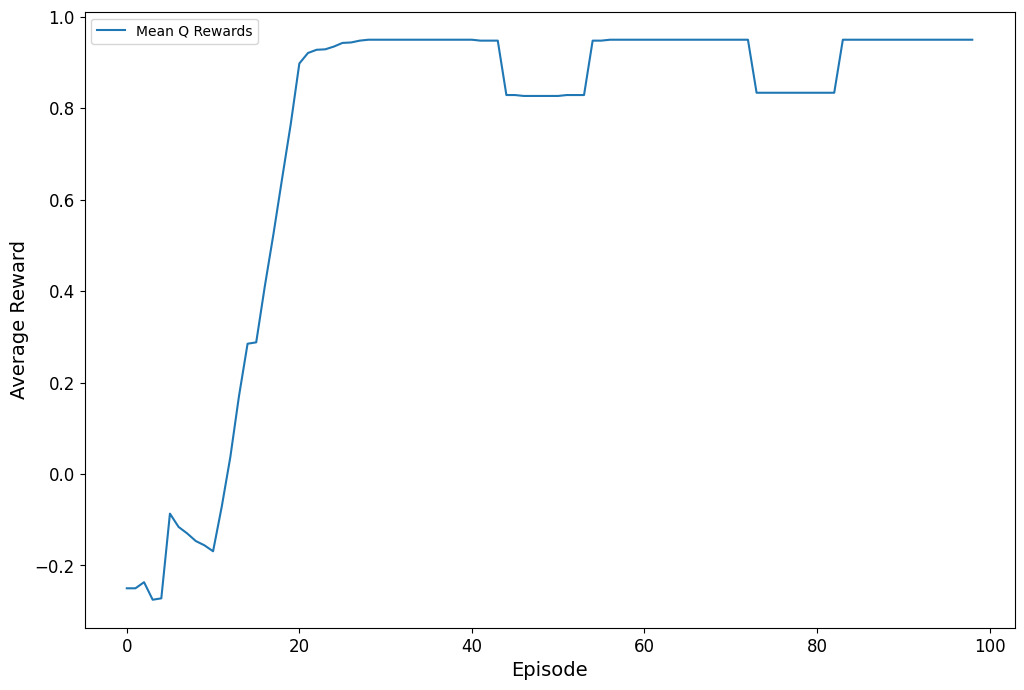

In [11]:
elf2.plot_q_training_curve()

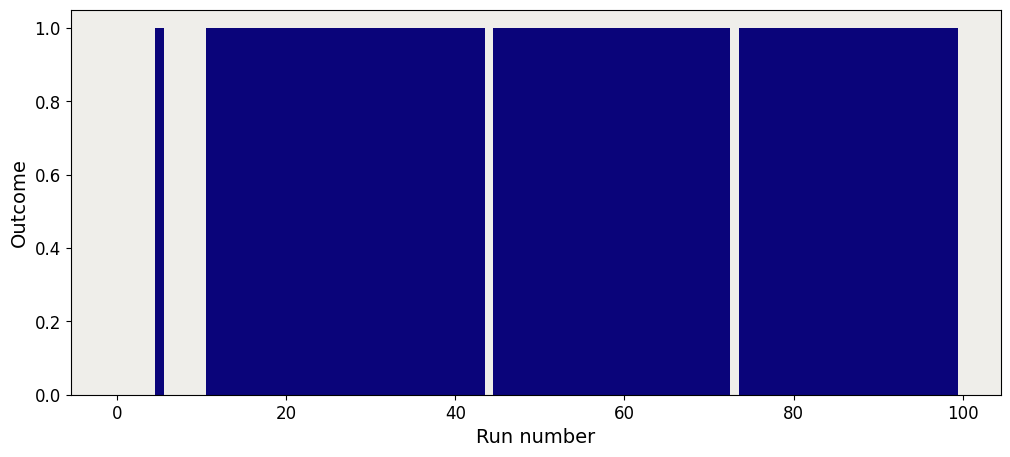

In [12]:
elf2.plot_q_training_wins()

Impressive! After a few iterations the agent is already achieving peak performance and winning the games consistently. We can also save the animation for the training process:

In [15]:
animation_training = plot_animation(elf2.frames, interval=50)

Compared to the random agent, this one is performing much better. We can see how, at the beginning, the agent is exploring the space surrounding it, but once it founds the shortest path towards the goal it is able to consistently achieve peak performance.

We can also save this animation to file:

In [16]:
from plot_utils import save_gif

save_gif(path='./animations/train_animation.gif', anim=animation_training)

Finally, let us test our agent's performance on some more iterations. In this case, the agent will only be applying the policy it has learnt during training

In [17]:
total_epochs, total_penalties = elf2.evaluate_performance(episodes=100, save_images=True)

100%|██████████| 100/100 [00:00<00:00, 366.11it/s]


In [18]:
print(f"Number of epochs: {total_epochs}")
print(f"Percentage of failure: {total_penalties / total_epochs * 100} %")

Number of epochs: 600
Percentage of failure: 0.0 %


Our agent has indeed learnt the perfect policy for the game. To check it, let's plot the animation for this validation and save it to file.

In [19]:
animation_eval = plot_animation(elf2.eval_frames, interval=50)

In [20]:
from plot_utils import save_gif

save_gif(path='./animations/eval_animation.gif', anim=animation_eval)